# Inicio

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
import plotly.express as px


from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
#from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.decomposition import PCA
#from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

#from tensor_forest.python import tensor_forest
#from tensorflow.python.ops import resources




COLAB = ('COLAB_GPU' in os.environ)  # True if we are in a Colab environment

# Origin of Zip file
FILENAME1 = 'train.csv'
FILENAME2 = 'test.csv'


if COLAB:
    DIRNAME = '/content/drive/My Drive/Colab Notebooks/TITANIC/data/'
else:
    DIRNAME = './'

if COLAB:
    # Mount drive
    from google.colab import drive
    import shutil
    
    drive.mount("/content/drive")
    shutil.copy(DIRNAME+FILENAME1, FILENAME1)
    shutil.copy(DIRNAME+FILENAME2, FILENAME2)

print('Ready!!')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Ready!!


In [3]:
#Reading train data from CSV
train_data = pd.read_csv(DIRNAME + FILENAME1)
#Convertimos el género en binatio
sex_bin = {"female": 0,"male": 1}
train_data['Sex'] = train_data['Sex'].map(sex_bin)

#vemos cuantas filas estan duplicadas
duplicated = train_data.duplicated().sum()

print("Duplicated rows:", duplicated)


Duplicated rows: 0


In [4]:
#Reading test data from CSV
test_data = pd.read_csv(DIRNAME + FILENAME2)
#Hacemos lo mismo para los datos de test
sex_bin = {"female": 0,"male": 1}
test_data['Sex'] = test_data['Sex'].map(sex_bin)

#Filas duplicadas
duplicated = test_data.duplicated().sum()

print("Duplicated rows:", duplicated)

Duplicated rows: 0


In [5]:
men = train_data.loc[train_data.Sex == 1]["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men*100)

% of men who survived: 18.890814558058924


In [6]:
#Same but with womens
women = train_data.loc[train_data.Sex == 0]["Survived"]
rate_women_survived = sum(women)/len(women)
print(" % de las mujeres que sobrevivieron", rate_women_survived * 100)

 % de las mujeres que sobrevivieron 74.20382165605095


In [7]:
#Los 'Embarked' que faltaban eran pocos podemos auto-completarlos
train_data['Embarked'].fillna("S", inplace=True)


In [8]:
#para meter 'Age' como feature necesitamos hacer algo dado que faltan el 20% de las edades
#vemos cuantas personas habia por cada categoria del titanic
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [9]:
#Vamos a sacar correlaciones para los datos numericos
numericos = train_data.select_dtypes(include = "number").columns
correlaciones = train_data.drop('PassengerId', axis =1).corr()
correlaciones #obtenemos una tabla con las correlaciones hechas entre todas las columnas

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,-0.549500
Sex,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,-0.182333
Age,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,1.000000


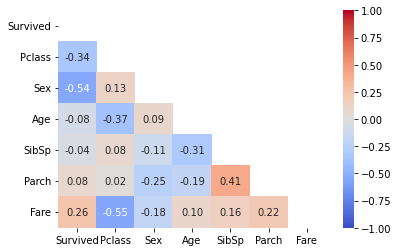

In [10]:
#Convertimos dicha tabla en una matriz para poder trabajar con ella
matrix = np.triu(correlaciones)
matrix

#Y lo representamos bonito:

sns.heatmap(correlaciones, vmin=-1, vmax=1, fmt='.2f', annot=True, mask=matrix, cmap='coolwarm', center=0)

In [11]:
#Hacemos correlaciones para columnas categoricas, no numeros!!
categoricos = train_data.select_dtypes(include = "object").columns

#Representamos las barras graficas para 
px.histogram(train_data, x="Pclass", color="Survived").show()

In [12]:
px.histogram(train_data, x='Embarked', color="Survived").show()


In [14]:
train_data.Cabin

0       NaN
1       C85
2       NaN
3      C123
4       NaN
       ... 
886     NaN
887     B42
888     NaN
889    C148
890     NaN
Name: Cabin, Length: 891, dtype: object

In [16]:
#Clasificacion con RandomForest

#Marcamos la columna de resultados de Train

Y = train_data["Survived"]


#Marcamos las columnas del dataset que vamos a utilizar para entrenar
#De momento falla el AGE
cols = ['Pclass', 'Sex' ,'SibSp', 'Parch']

#Extraemos del data-set las variables que vamos a utilizar
#Y las convertimos en tipo 'indicadoras'
X_train = pd.get_dummies(train_data[cols])
X_test = pd.get_dummies(test_data[cols])


#Creamos nuestro modelo y lo entrenamos
model = RandomForestClassifier(n_estimators = 110, max_depth = 7, random_state = 42)
model.fit(X_train, Y)
#predecimos nuestras Y con los datos de test
predictions = model.predict(X_test)


#Creamos la salida  para que sea un data-set con el fromato pedido
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})



output.to_csv('/content/drive/My Drive/Colab Notebooks/TITANIC/submission.csv', index = False)
print("CSV guardado!")





CSV guardado!


In [32]:
#Prueba para clasificar con modelo KNN

model2 = KNeighborsClassifier(n_neighbors = 5)
model2.fit(X_train,Y)
predictions2 = model2.predict(X_test)


output2 = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions2})
output2.to_csv('/content/drive/My Drive/Colab Notebooks/TITANIC/submission2.csv', index = False)
print("CSV guardado!")

output2.head(10)

CSV guardado!


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,1
8,900,1
9,901,0


In [31]:


#Vamos a intentar entrenar 3 modelos a la vez
Model3 = AdaBoostClassifier(random_state=0)

Model3.fit(X_train, Y)
predictions3 = Model3.predict(X_test)

output3 = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions3})
output3.to_csv('/content/drive/My Drive/Colab Notebooks/TITANIC/submission3.csv', index = False)
print("CSV guardado!")
    

    


CSV guardado!
